In [1]:
from comet import COMET
from models.encoder import FTClassifier
# import datautils
from tasks.fine_tuning import finetune_fit
from tasks.fine_tuning import finetune_predict
from tasks.linear_evaluation import eval_classification
from dataloading.ptb_preprocessing import load_ptb
from config_files.PTB_Configs import Config as Configs

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from utils import plot_channels
from utils import process_batch_ts
from utils import split_data_label
from utils import start_logging
from utils import stop_logging
from utils import seed_everything

from datetime import datetime

In [2]:
configs = Configs()
RANDOM_SEED = configs.RANDOM_SEED

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Specify saving and logging directory

In [3]:
working_directory = configs.working_directory
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = configs.logging_directory
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

In [4]:
test = np.load("datasets/PTB/Label/label.npy")
test

array([[  1,   1],
       [  1,   2],
       [  1,   3],
       [  1,   4],
       [  1,   5],
       [  1,   6],
       [  1,   7],
       [  1,   8],
       [  1,   9],
       [  1,  10],
       [  1,  11],
       [  1,  12],
       [  1,  13],
       [  1,  14],
       [  1,  15],
       [  1,  16],
       [  1,  17],
       [  1,  18],
       [  1,  19],
       [  1,  20],
       [  1,  21],
       [  1,  22],
       [  1,  23],
       [  1,  24],
       [  1,  25],
       [  1,  26],
       [  1,  27],
       [  1,  28],
       [  1,  29],
       [  1,  30],
       [  1,  31],
       [  1,  32],
       [  1,  33],
       [  1,  34],
       [  1,  35],
       [  1,  36],
       [  1,  37],
       [  1,  38],
       [  1,  39],
       [  1,  40],
       [  1,  41],
       [  1,  42],
       [  1,  43],
       [  1,  44],
       [  1,  45],
       [  1,  46],
       [  1,  47],
       [  1,  48],
       [  1,  49],
       [  1,  50],
       [  1,  51],
       [  1,  52],
       [  1,

#### Load and preprocessing data

In [5]:
test = np.load("datasets/PTB/Label/label.npy")
negative_list = list(test[np.where(test[:,0]==0)][:,1])
positive_list = list(test[np.where(test[:,0]==1)][:,1])
print(negative_list)  # healthy ID
print(positive_list)  # positive ID

[104, 105, 108, 109, 111, 112, 114, 124, 126, 127, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 147, 151, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 179, 180, 182, 183, 187, 188, 192]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 110, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 128, 129, 130, 140, 143, 144, 145, 146, 148, 149, 150, 152, 153, 155, 156, 176, 178, 181, 184, 185, 186, 189, 190, 191, 193, 194, 195, 196, 197, 198]


In [6]:
data_path = "datasets/PTB/Feature/"
label_path = "datasets/PTB/Label/label.npy"
train_ids = negative_list[:-14] + positive_list[:-42]  # specify patient ID for training, validation, and test set
val_ids = negative_list[-14:-7] + positive_list[-42:-21]   # 28 patients, 7 healthy and 21 positive
test_ids = negative_list[-7:] + positive_list[-21:]  # # 28 patients, 7 healthy and 21 positive
X_trial_train, X_trial_val, X_trial_test, y_trial_train, y_trial_val, y_trial_test = load_ptb(train_ids, val_ids, test_ids, data_path, label_path)
print(X_trial_train.shape)
print(y_trial_train.shape)
print(X_trial_val.shape)
print(y_trial_val.shape)
print(X_trial_test.shape)
print(y_trial_test.shape)

Validation subjects:  [170, 171, 172, 173, 174, 175, 177, 110, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 128, 129, 130, 140, 143, 144, 145, 146, 148]
Test subjects:  [179, 180, 182, 183, 187, 188, 192, 149, 150, 152, 153, 155, 156, 176, 178, 181, 184, 185, 186, 189, 190, 191, 193, 194, 195, 196, 197, 198]
(5395, 3000, 15)
(5395, 2)
(340, 3000, 15)
(340, 2)
(502, 3000, 15)
(502, 2)


In [7]:
# normalize data
X_trial_train = process_batch_ts(X_trial_train, normalized=True, bandpass_filter=False)
X_trial_val = process_batch_ts(X_trial_val, normalized=True, bandpass_filter=False)
X_trial_test = process_batch_ts(X_trial_test, normalized=True, bandpass_filter=False)
print(X_trial_train.shape)
print(X_trial_val.shape)
print(X_trial_test.shape)

(5395, 3000, 15)
(340, 3000, 15)
(502, 3000, 15)


In [8]:
# Split trail-level data into sample-level data
X_train, y_train = split_data_label(X_trial_train,y_trial_train, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_val, y_val = split_data_label(X_trial_val,y_trial_val, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_test, y_test = split_data_label(X_trial_test,y_trial_test, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(53950, 300, 15)
(3400, 300, 15)
(5020, 300, 15)
(53950, 3)
(3400, 3)
(5020, 3)


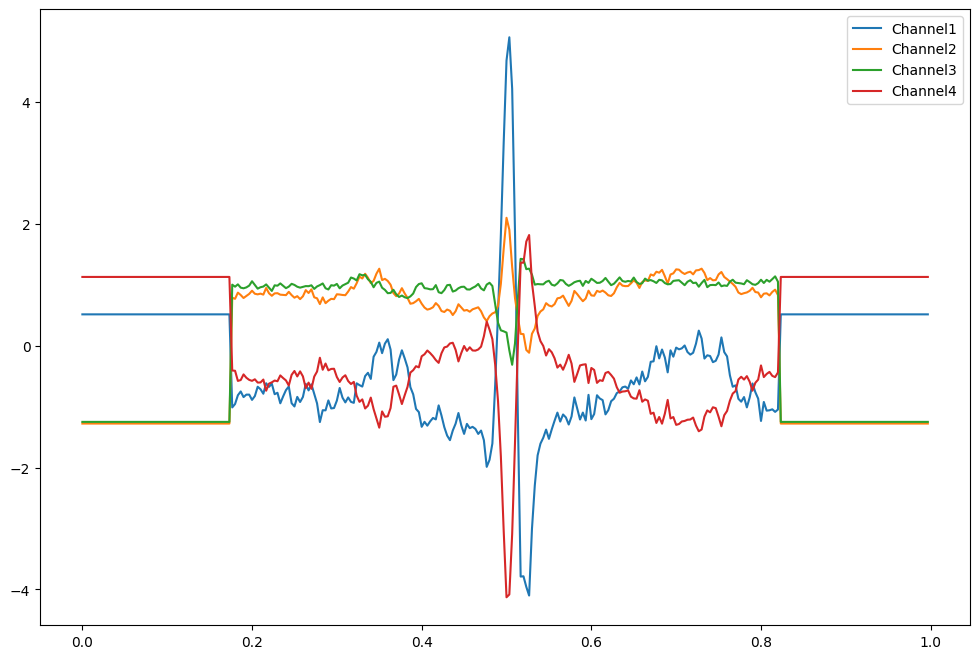

In [9]:
# plot first sample, first four channels
plot_channels(1, X_train[0][:,:4])

## Train model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The program will run on {device}!")

The program will run on cuda!


### Callback functions

In [11]:
def pretrain_callback(model, loss):
    n = model.n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, X_train, y_train[:, 0], X_val, y_val[:, 0], fraction=1)
        print(metrics_dict)
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [12]:
def finetune_callback(model, f1, fraction=1.0):
    n = model.n_epochs
    if model.n_epochs == 1:
        model.finetune_f1 = f1
        torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    # control the saving frequency
    if n % 1 == 0:
        if f1 > model.finetune_f1:
            model.finetune_f1 = f1
            torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    return finetune_callback

## Self-Supervised

In [13]:
start_time = datetime.now()
# Train a COMET model
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    after_epoch_callback=pretrain_callback,
)

epoch_loss_list, epoch_f1_list = model.fit(
    X_train,
    y_train,
    shuffle_function = configs.shuffle_function,
    verbose=configs.verbose,
    n_epochs=configs.n_epochs,
    masks = configs.masks,
    factors = configs.factors
)

end_time = datetime.now()
print(f'Duration: {end_time - start_time}')

Epoch #1: loss=8.290429587634105
{'Accuracy': 0.755, 'Precision': 0.7432310343200383, 'Recall': 0.700349069776218, 'F1': 0.7106586657995212, 'AUROC': 0.8799909430544549, 'AUPRC': 0.8621251373365453}
Epoch #2: loss=7.223039222213457
{'Accuracy': 0.795, 'Precision': 0.7905513929828316, 'Recall': 0.7489659987169327, 'F1': 0.7613319245692862, 'AUROC': 0.8863375976451942, 'AUPRC': 0.871654081977808}
Epoch #3: loss=7.011759978420329
{'Accuracy': 0.7744117647058824, 'Precision': 0.7545148737223089, 'Recall': 0.7477772746141363, 'F1': 0.7507786613857252, 'AUROC': 0.856693837503302, 'AUPRC': 0.833491421882819}
Epoch #4: loss=6.8938708080435696
{'Accuracy': 0.7708823529411765, 'Precision': 0.7505097339941205, 'Recall': 0.7442978980338881, 'F1': 0.7470815690109893, 'AUROC': 0.8496501754783199, 'AUPRC': 0.8215840139579689}
Duration: 0:05:42.565375


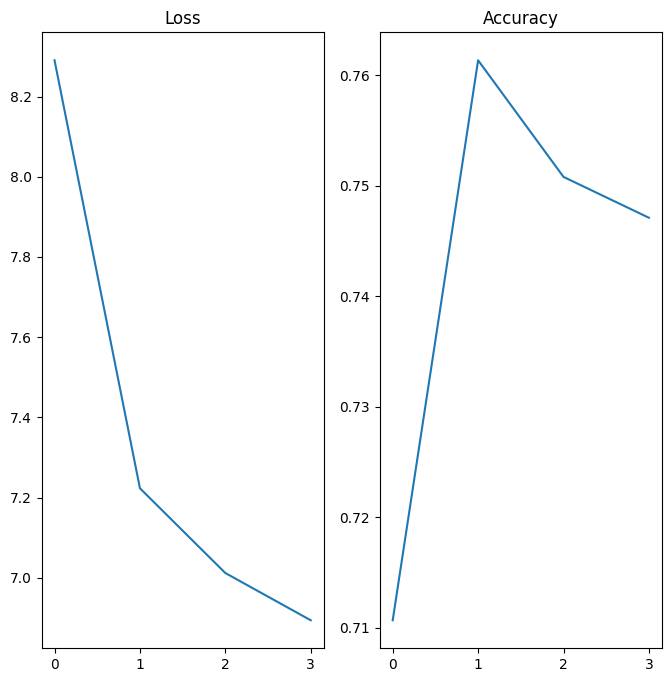

In [14]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Linear evaluation

In [15]:
start_time = datetime.now()
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    after_epoch_callback=pretrain_callback,
)

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

start_logging(RANDOM_SEED, logging_directory)
val_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_val, y_val[:, 0])
print("Linear evaluation for validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_test, y_test[:, 0])
print("Linear evaluation for test set\n",test_metrics_dict)
print()
stop_logging()

Linear evaluation for validation set
 {'Accuracy': 0.7708823529411765, 'Precision': 0.7505097339941205, 'Recall': 0.7442978980338881, 'F1': 0.7470815690109893, 'AUROC': 0.8496501754783199, 'AUPRC': 0.8215840139579689}


## Full fine-tuning

In [16]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes).to(device)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [17]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_100, finetune_epochs=configs.finetune_epochs_100, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_100, fraction=configs.fraction_100, device=device, callback=finetune_callback)

In [18]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_100}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_100} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_100} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

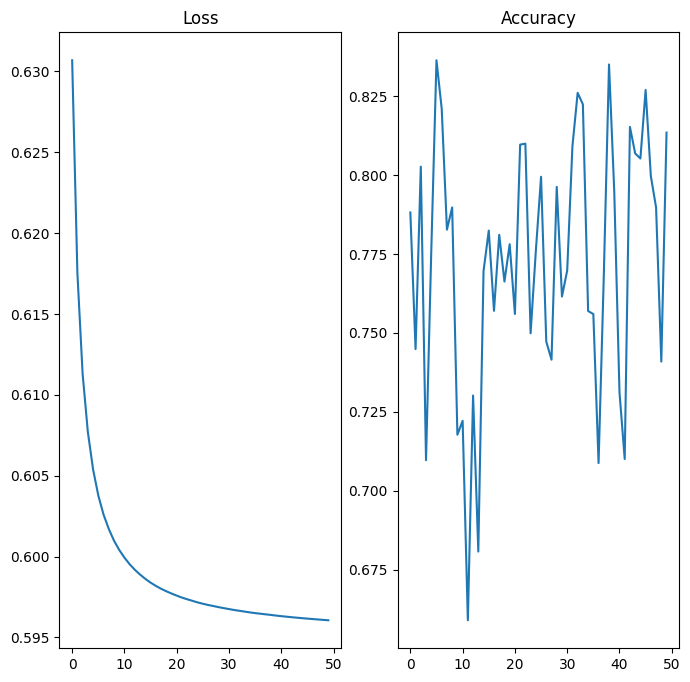

In [19]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 10% label

In [20]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes).to(device)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [21]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_10,finetune_epochs=configs.finetune_epochs_10, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_10, fraction=configs.fraction_10, device=device, callback=finetune_callback)

In [22]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_10}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_10} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_10} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

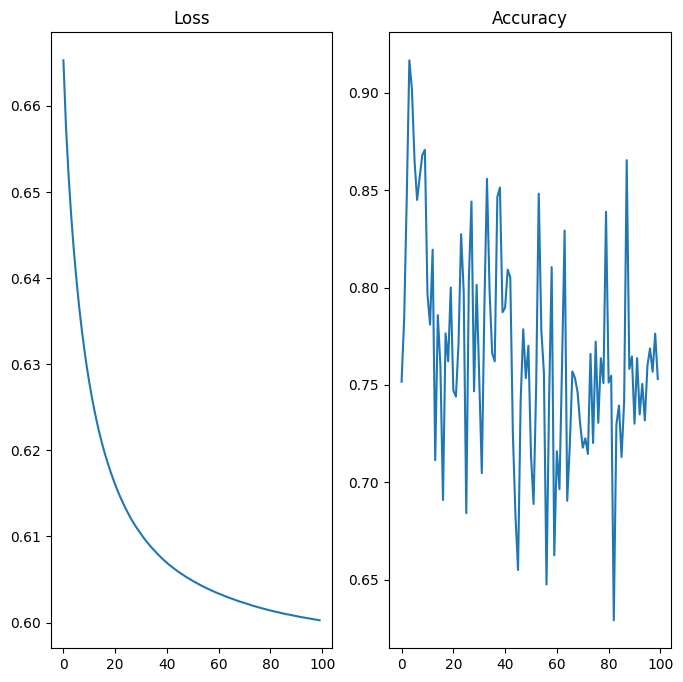

In [23]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 1% label

In [24]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes).to(device)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [25]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=configs.finetune_epochs_1, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_1, fraction=configs.fraction_1, device=device, callback=finetune_callback)

In [26]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_1}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_1} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_1} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

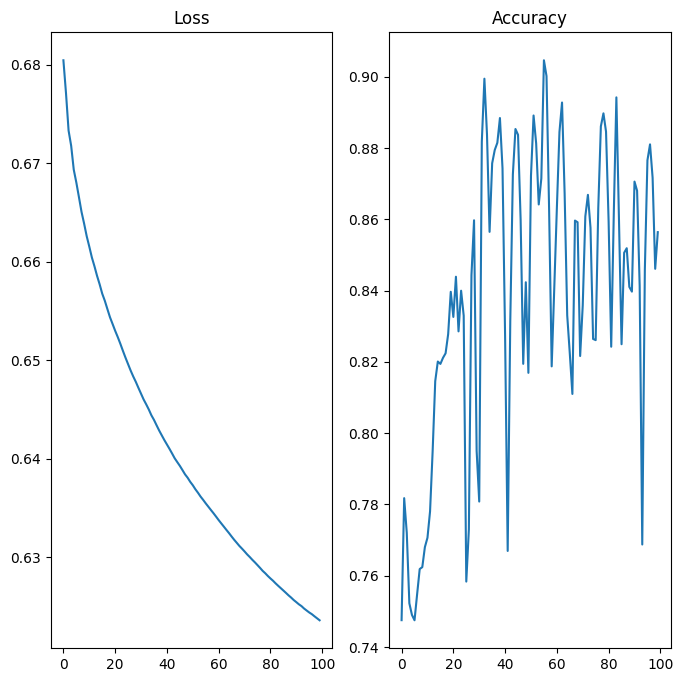

In [27]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

In [28]:
end_time = datetime.now()
print(f'Duration: {end_time - start_time}')